In [6]:
import numpy             as np
import matplotlib.pyplot as plt
from time import time

from matplotlib          import rcParams, rc
# Change the matplotlib default parameters
# rcParams.update({'font.size':   12})
rcParams.update({'figure.dpi': 120})
# rc('font', family='serif')
# rc('text', usetex=True)

from astropy import units as units


from src.rates          import initialise_abs, calculate_rates, read_specs_file
from src.input          import getcst, density

from scipy.integrate    import solve_ivp
from astropy            import constants

rate = 13
if rate == 13:
    from src.ode.dcodes     import ODE
if rate == 16:
    from src.ode.acodes     import ODE

specs, parnt, consv = read_specs_file('C', rate)

specs_dict = dict()
for i in range(len(specs)):
    specs_dict[specs[i]] = i

In [8]:
time()

1687355422.9381096

In [15]:
## input values physics
def setinput(Mdot, vexp, r, T, δ, Av, chemtype):
    '''
    Set input values of the model.

    INPUT:
        - ρ  = density       [g/cm^3]
            via mass-loss rate (Mdot [Msol/yr]) & expansion velocity (vexp [km/s])
        - T  = temperature   [K]
        - δ  = outwards dilution of radiation field     == RAD
        - Av = outward dus extinction
        - chemtype = type of chemistry: 'C' or 'O'
    '''

    ## input physics
    ρ = density(Mdot, vexp, r)

    print('| Input:')
    print('|    ρ  =','{:.2E}'.format(ρ),'  T  =',T,'   δ  =',δ,'    Av =',Av)
    print('|    Chem type =', chemtype,'    Rate =', rate)

    return ρ, T, δ, Av, chemtype



def plot(ts, ys, title, type, lowlim = 10e-308, molecs = None):
    fig = plt.figure(figsize=(8,6))

    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    axs = [ax1,ax2]

    ax1.set_title(title)

    if molecs == None:
        for i in range(ys.shape[0]):
            ax1.plot(ts, ys[i], alpha = 0.5, lw = 0.5, ms = 2)
            ax2.plot(ts, -ys[i], alpha = 0.8, lw = 0.5)

    if molecs != None:
        for imol in molecs:
            ax1.plot(ts, ys[imol], alpha = 0.5, lw = 0.5,ms = 2, label = specs[imol])
            ax2.plot(ts, -ys[imol], alpha = 0.8, lw = 0.5)

    for ax in axs:
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim((lowlim, 1.0e+0))

        # ax.set_xlim(0, 1.e-3)

    ax2.set_xlabel('time [s]')
    if type == 'y':
        ax1.set_ylabel('abundance')
        ax2.set_ylabel('negative abundance')
    if type == 'ydot':
        ax1.set_ylabel('ydot')
        ax2.set_ylabel('-ydot')
    ax1.set(xticklabels=[])
    ax2.invert_yaxis()

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.05)
    ax1.legend(fontsize = 7)
    plt.show()

    return

def search_negs(ys, elwise = False, el = None):
    '''
    Search for species that contain negative values
    '''
    idx = list()

    if elwise == False:
        for ispec in range(ys.shape[0]):
            if np.any(ys[ispec] < 0):
                idx.append(ispec)

    if elwise == True:
        # print(ys.shape)
        for ispec in range(ys.shape[0]):
            if np.any(ys[ispec][el] < 0):
                # print(i,el)
                idx.append(ispec)


    molecs = list()

    for i in idx:
        molecs.append(specs[i])

    return idx, molecs

def search_zeros(ys, elwise = False, el = None):
    '''
    Search for species that contain zero values.
    '''

    idx = list()

    if elwise == False:
        for ispec in range(1,ys.shape[0]):
            if np.any(ys[ispec] == 0):
                idx.append(ispec)

    if elwise == True:
        # print(ys.shape)
        for ispec in range(1,ys.shape[0]):
            if np.any(ys[ispec][el] == 0):
                idx.append(ispec)


    molecs = list()

    for i in idx:
        molecs.append(specs[i])

    return idx, molecs

def write_out(ts, ys,filename = 'chemtorch.out'):

    out = np.array(ys)


    loc = './out/'
    with open(loc+filename, 'w') as f:
        f.write('{0:11}'.format('TIME [yr]'))
        for spec in specs:
            f.write('{0:11}'.format(spec))
        f.write('\n')
        for i in range(out.shape[1]):
            f.write('{:.12e}'.format(ts[i]/yr_to_sec)+'  ')
            for j in range(out.shape[0]):
                f.write('{:.12e}'.format(out[j][i])+'  ')
            f.write('\n')
    return            


In [12]:
1e5/yr_to_sec

0.003168808781402895

### Test simulations

In [3]:
## constants
kB, mH, rGr, nGr, stckH, AUV_AV = getcst()
yr_to_sec = units.year.to('s')         ## year in seconds

In [4]:
Mdots = np.array([1.e-8, 1.e-5])#, 1.e-7, 1.e-6, 1.e-5])
vexps = np.array([5., 20.])#,10.,15.,20.])
Ts = np.array([2500.])
chemtype = np.array(['C', 'O'])

In [28]:
def solve(ρ, T, δ, Av, chemtype, Δt, atol = 1.e-30, rtol = 1.e-7):
    '''
    Solve the chemical ODE, given by the ODE function. \n
    Returns t, y, ydot.
    '''

    ## calculate H accretion on dust
    Haccr = stckH *np.pi*(rGr**2.0)*ρ*nGr*(8.0*kB*T/(np.pi*mH))**0.5

    ## set initial conditions
    n, nconsv_tot, specs = initialise_abs(chemtype, rate)     # nconsv_tot = TOTAL in fortran code
    timesteps = 1

    ndot        = np.zeros(len(n))
    nconsv      = np.zeros(len(nconsv_tot))
    t           = np.zeros(timesteps)

    k = calculate_rates(T, δ, Av, rate)

    Δt = Δt*yr_to_sec  ## in sec

    # solvers = ['RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA']

    print(' >> Solving ODE with Δt',Δt,'...')
    tic = time()
    ## solve ODE
    solution = solve_ivp(
        fun          = ODE,
        t_span       = [0.0, Δt],
        y0           = n.astype(np.float64),
        method       = 'BDF',   ## zoals DVODE
        args         = (ndot, nconsv, nconsv_tot,k, ρ, Haccr),
        dense_output = False,    ## if True: returns interpolation function
        atol         = atol,
        rtol         = rtol
        )
    toc = time()

    assert solution['status'] == 0

    ys = solution['y']
    ts = solution['t']

    print(solution['message'])
    print(' >> Calculating ydot for solution...')
    # ydot = [ODE(t, ys[:,i], ndot, nconsv, nconsv_tot,k, ρ, Haccr) for i in range(ys.shape[1])]
    print('DONE!')
    print('')

    return ts, ys,  toc-tic# np.array(ydot).T

In [29]:
ts_O = dict()
ys_O = dict()
ydot_O = dict()
time_O = dict()

for i in range(len(Mdots)):
    print(i)
    ρ, T, δ, Av, chemtype= setinput(Mdots[i],vexps[i], 1.e15, Ts[0], 1., 0.5, 'O')
    ts_O[i], ys_O[i],  time_O[i] = solve(ρ, T, δ, Av, chemtype, 4.e-3)


0
| Input:
|    ρ  = 2.25E+04   T  = 2500.0    δ  = 1.0     Av = 0.5
|    Chem type = O     Rate = 13
 >> Solving ODE with Δt 126230.40000000001 ...
The solver successfully reached the end of the integration interval.
 >> Calculating ydot for solution...
DONE!

1
| Input:
|    ρ  = 5.63E+06   T  = 2500.0    δ  = 1.0     Av = 0.5
|    Chem type = O     Rate = 13
 >> Solving ODE with Δt 126230.40000000001 ...
The solver successfully reached the end of the integration interval.
 >> Calculating ydot for solution...
DONE!



In [30]:
time_O

{0: 26.318099975585938, 1: 47.17790675163269}

In [15]:
ts_C = dict()
ys_C = dict()
ydot_C = dict()

for i in range(len(Mdots)):
    ρ, T, δ, Av, chemtype= setinput(Mdots[i],vexps[i], 1.e15, Ts[0], 1., 1., 'C')
    ts_C[i], ys_C[i], ydot_C[i] = solve(ρ, T, δ, Av, chemtype, 1.e1)

| Input:
|    ρ  = 2.25E+04   T  = 2500.0    δ  = 1.0     Av = 1.0
|    Chem type = C     Rate = 13
 >> Solving ODE with Δt 315576000.0 ...
The solver successfully reached the end of the integration interval.
 >> Calculating ydot for solution...
DONE!

| Input:
|    ρ  = 5.63E+06   T  = 2500.0    δ  = 1.0     Av = 1.0
|    Chem type = C     Rate = 13
 >> Solving ODE with Δt 315576000.0 ...
The solver successfully reached the end of the integration interval.
 >> Calculating ydot for solution...
DONE!



In [18]:
ts = {'O': ts_O}#, 'C' : ts_C}
ys = {'O': ys_O}#, 'C' : ys_C}
# ydot = {'O': ydot_O}#, 'C' : ydot_C}

In [31]:
chemtype = 'O'
write_out(ts[chemtype][0],ys[chemtype][0], filename = 'Radau13-'+chemtype+'-rho2.25E+04-T2500-d1-Av1-time26.318099975585938.out')
write_out(ts[chemtype][1],ys[chemtype][1], filename = 'Radau13-'+chemtype+'-rho5.63E+06-T2500-d1-Av1-time47.17790675163269.out')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


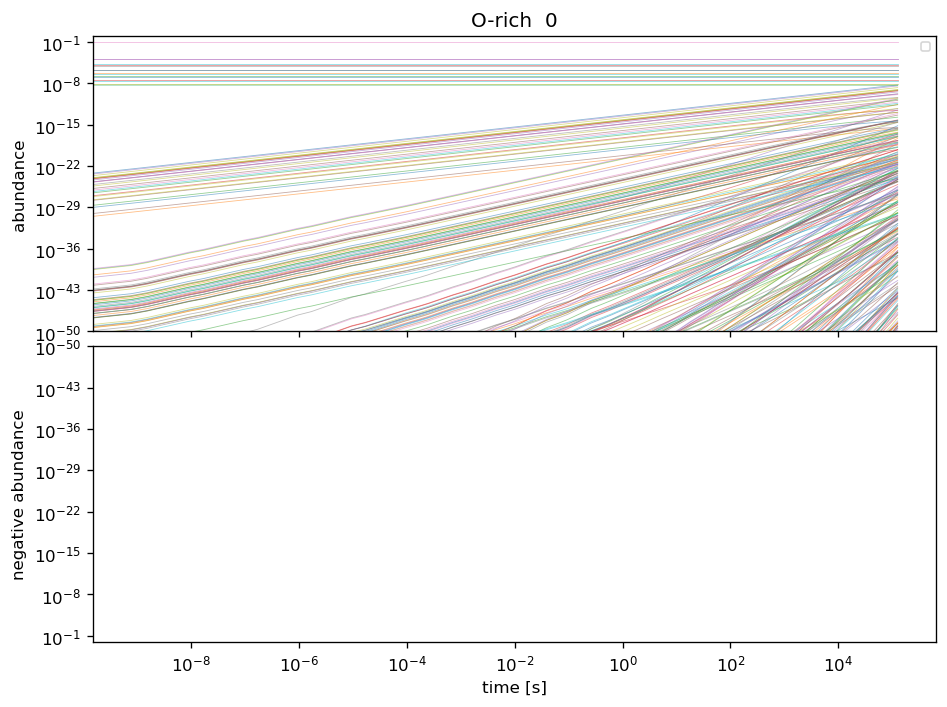

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


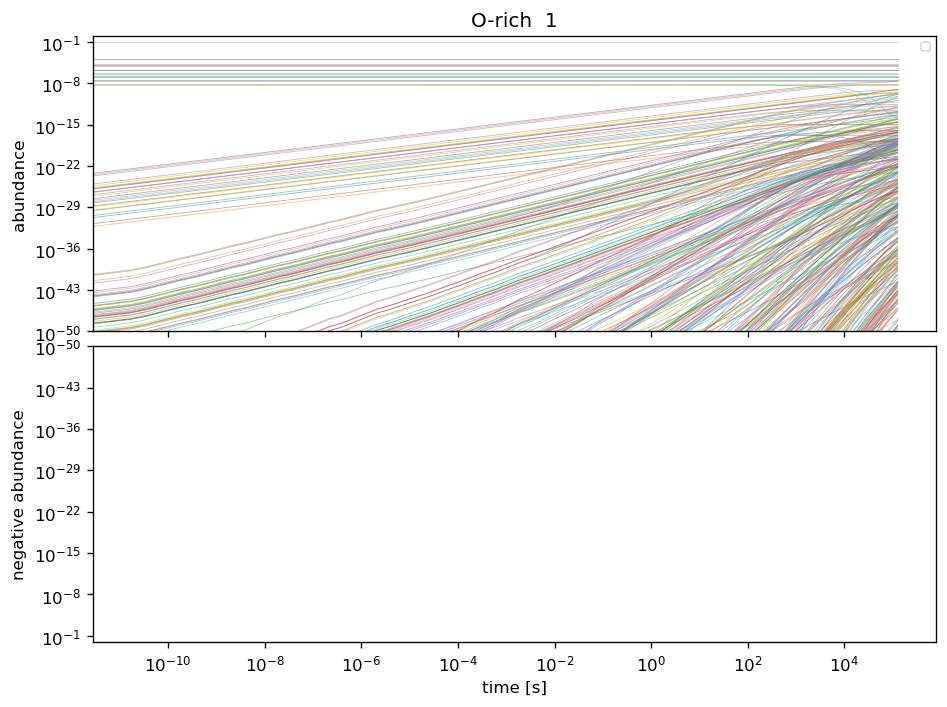

In [22]:
# molecs = [180, 194, 182,27,9,4, 6, 0, 27]     ## CNO
# molecs = [6,182,4,173,194]                    ## HONC+
# molecs = [17, 336]                            ## C5N+

chemtype = 'O'
molecs = None
for i in range(len(Mdots)):
    plot(ts[chemtype][i],(  ys[chemtype][i]), chemtype+'-rich  '+str(i),'y'   , molecs = molecs, lowlim = 1.e-50)
    # plot(ts[chemtype][i],(ydot[chemtype][i]), chemtype+'-rich '+str(i),'ydot', molecs = molecs)

### Search for zeros

In [9]:
sim  = 2
y   = ys[chemtype][sim]
dot = ydot[chemtype][sim]
t   = ts[chemtype][sim]

In [10]:
for el in range(1,y.shape[1]-1):
    idx_zero, specs_zero = search_zeros(y, elwise = True, el=el)
    length = len(idx_zero)
    if el == 1:
        print('Zero values on position', 1)
        print('#:',length)
        for i in range(length):
            print(idx_zero[i], specs_zero[i])
    elif length != 0:
        print('\nZero values on position',el)
        print('#:',length)
        print(idx_zero)
        print(specs_zero)

Zero values on position 1
#: 136
11 CH-
44 Na
45 Na+
48 Mg
49 Mg+
101 C2H7+
109 SiH4+
133 C3-
137 C3H-
165 C3H6+
173 CNO
180 HCNO+
182 HONC
194 HONC+
196 HCNOH+
208 H2CNO+
224 H2SiO
234 PCH3+
235 H2SiO+
252 H3SiO+
253 C4-
265 C4H-
275 ClO
276 ClO+
280 CH2CHCCH
285 C4H4+
306 CCP+
311 Fe+
315 Fe
320 PC2H3+
325 C5
328 C5-
332 C5+
336 C5H+
338 C5H
340 C5H-
341 C5H2+
343 C5H2
344 C4N
346 C5H3+
347 CH3C4H
350 SiC3+
351 CH3C4H+
353 SiC3
358 SiC3H+
362 SiC3H
363 C5H5+
366 SiC3H2+
370 C3P
371 PC3H+
375 C6-
376 C6+
377 C6
378 C6H
379 C6H+
380 C6H-
381 C6H2
382 C6H2+
384 C5N-
385 C5N+
388 C6H3+
389 SiC4+
390 C6H4+
392 SiC4
394 SiC4H+
395 C6H5+
396 C6H6
397 C6H6+
398 C4P
399 C6H7+
400 C4P+
401 C4S
402 PC4H+
403 C4S+
404 HC4S+
405 C7+
406 C7
407 C7-
408 C7H-
409 C7H+
410 C7H
411 C7H2+
412 C7H2
413 C7H3+
414 C7H4+
415 CH3C6H
416 CH3C5N
417 C7H5+
418 CH3C5NH+
419 C8-
420 C8
421 C8+
422 C8H
423 C8H+
424 C8H-
425 C8H2
426 C7N
427 C7N+
428 C8H2+
429 HC7N
430 HC7N+
431 C8H3+
432 C8H4+
433 H2C7N+
434 C8H5

### Search for negatives

In [11]:
idx_neg, specs_neg = search_negs(y)
print('Negative values overal:')
print('#:',len(idx_neg))
print(idx_neg)
print(specs_neg)

print('')

el = 1
for el in range(y.shape[1]-1):
    idx_neg, specs_neg = search_negs(y, elwise = True, el=el)
    length = len(idx_neg)
    if el == 1:
        print('Negative values on first position:')
        print('#:',length)
        for i in range(length):
            print(idx_neg[i], specs_neg[i])
    if length != 0:
        print('\nNegative values on position',el)
        print('#:',length)
        print(idx_neg)
        print(specs_neg)


Negative values overal:
#: 2
[73, 81]
['C2H4', 'C2H5']

Negative values on first position:
#: 2
73 C2H4
81 C2H5

Negative values on position 1
#: 2
[73, 81]
['C2H4', 'C2H5']

Negative values on position 2
#: 2
[73, 81]
['C2H4', 'C2H5']

Negative values on position 3
#: 2
[73, 81]
['C2H4', 'C2H5']

Negative values on position 4
#: 2
[73, 81]
['C2H4', 'C2H5']

Negative values on position 6
#: 1
[81]
['C2H5']


/tmp/ipykernel_31422/4260766717.py:25: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 1.e9)


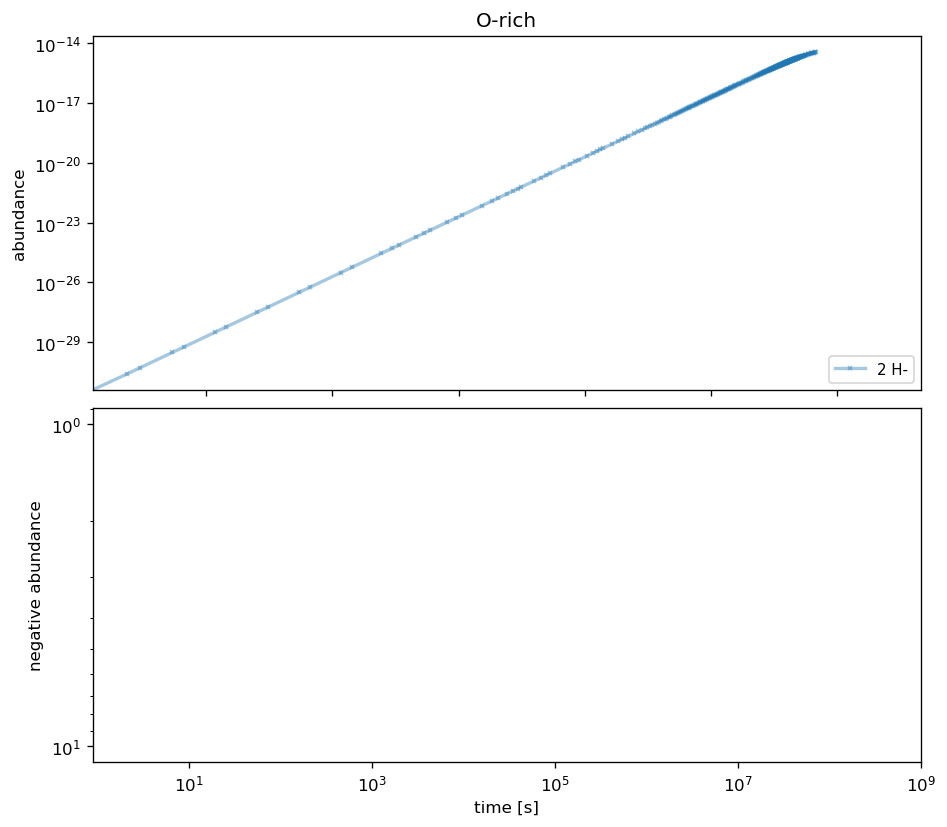

In [12]:
nbs = [184,208,196,4,16,87, 173,71] ## CNO related specs
nbs = [394,55,293,267,52,282,70]    ## SiC4H+ related specs
nbs = [438, 440, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465] ## zero on 2nd position
nbs = [2]

fig = plt.figure(figsize=(8,7))

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
axs = [ax1,ax2]

ax1.set_title('O-rich')

for nb in nbs:
    ax1.loglog(t, (y[nb]), label = str(nb) + ' '+ specs[nb], alpha = 0.4, lw = 2, marker='x', ms = 2)
    ax1.loglog(t, -(y[nb]), alpha = 0.4, lw = 2, marker='x', ms = 2)
    


ax1.legend(loc = 'lower right', fontsize = 9)
for ax in axs:
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_xlim(0, 1.e9)

ax2.set_xlabel('time [s]')
ax1.set_ylabel('abundance')
ax1.set(xticklabels=[])
ax2.set_ylabel('negative abundance')
ax2.invert_yaxis()

fig.tight_layout()
fig.subplots_adjust(hspace=0.05)
plt.show()

In [13]:
y[297]

array([0.00000000e+000, 7.66055450e-234, 2.93348409e-233, 9.64925438e-226,
       3.41122740e-225, 9.83779074e-218, 3.45742897e-217, 9.85674607e-210,
       3.46240914e-209, 9.86119680e-202, 3.49379835e-201, 1.00143568e-193,
       6.95860124e-193, 1.30726027e-184, 7.71893990e-183, 1.55702081e-181,
       5.72989724e-175, 2.35712270e-173, 3.81920854e-172, 4.16986417e-165,
       1.76213293e-163, 2.90390560e-162, 4.57630692e-154, 2.20873950e-152,
       3.93310862e-151, 2.71156321e-148, 7.20817068e-147, 9.56491613e-146,
       8.60958212e-145, 1.31806566e-139, 8.32882116e-138, 3.06746586e-136,
       6.59031801e-135, 1.38064356e-129, 4.15225072e-127, 2.66459476e-125,
       6.94163594e-124, 1.44577334e-120, 1.17990056e-118, 3.65093795e-117,
       6.16769021e-116, 6.86096430e-115, 3.43325517e-111, 3.34847534e-109,
       1.13201486e-107, 2.02709770e-106, 2.35069397e-105, 5.24549648e-103,
       1.93041994e-101, 3.53614549e-100, 4.14533286e-099, 3.52492020e-098,
       2.34469597e-097, 2

In [14]:
ys_O[0][0]

array([0.00000000e+00, 3.33211135e-23, 6.66422269e-23, 3.99853362e-22,
       7.33064496e-22, 4.06517584e-21, 7.39728719e-21, 4.07184007e-20,
       7.40395141e-20, 4.07250649e-19, 7.40461783e-19, 4.07257313e-18,
       7.40468447e-18, 1.67126782e-17, 2.60206720e-17, 3.53286658e-17,
       5.73318883e-17, 7.93351108e-17, 1.01338333e-16, 2.06764462e-16,
       3.12190589e-16, 4.17616715e-16, 1.10606659e-15, 1.79451641e-15,
       2.48296619e-15, 6.60226824e-15, 1.07215685e-14, 1.48408671e-14,
       1.89601638e-14, 5.16330911e-14, 8.43059075e-14, 1.16978613e-13,
       1.49651208e-13, 3.86990761e-13, 6.24324470e-13, 8.61652336e-13,
       1.09897436e-12, 1.66880614e-12, 2.23860424e-12, 2.80836865e-12,
       3.37809937e-12, 4.57677561e-12, 5.77530271e-12, 6.97368069e-12,
       8.17190953e-12, 9.36998926e-12, 1.32608320e-11, 1.71501016e-11,
       2.10377983e-11, 2.49239224e-11, 2.88084742e-11, 3.56500084e-11,
       4.24866625e-11, 4.93184383e-11, 5.61453376e-11, 6.29673619e-11,
      